In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./creditcard.csv')

# Transformation

In [5]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [6]:
amt = np.array(df['Amount']).reshape(-1, 1)
amt_scaled = ss.fit_transform(amt)

In [7]:
df['Amount'] = amt_scaled

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Resampling

In [9]:
from sklearn.utils import resample

df_majority = df[df.Class==0]
df_minority = df[df.Class==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=len(df_minority),     
                                 random_state=5) 

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_minority_ma = df_minority.rolling(window=3).mean()

df_minority_ma = df_minority_ma.dropna()

df_minority_extended = pd.concat([df_minority, df_minority_ma])

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=1000,   
                                 random_state=123) 

df_upsampled = pd.concat([df_majority_downsampled, df_minority_extended])

print(len(df_upsampled), len(df_downsampled), len(df))

1982 984 284807


# Split

In [10]:
from sklearn.model_selection import train_test_split

X_up, y_up = df_upsampled.iloc[:,:-1], df_upsampled.iloc[:,-1:]
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.3, random_state=5)

X_down, y_down = df_downsampled.iloc[:,:-1], df_downsampled.iloc[:,-1:]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.3, random_state=5)

X, y = df.iloc[:,:-1], df.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


# Models

# Logistic regression

Best parameters for the upsampled data:  {'C': 100}
Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


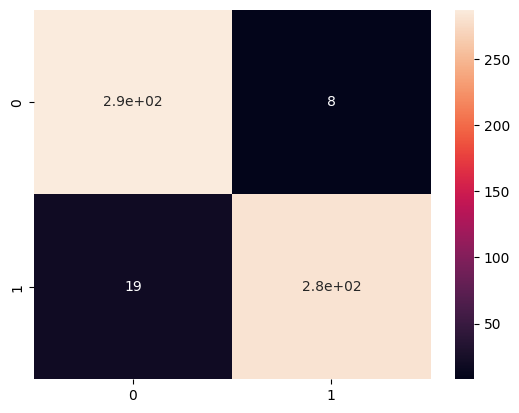

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       295
         1.0       0.97      0.94      0.95       300

    accuracy                           0.95       595
   macro avg       0.96      0.95      0.95       595
weighted avg       0.96      0.95      0.95       595

Best parameters for the downsampled data:  {'C': 1000}
Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


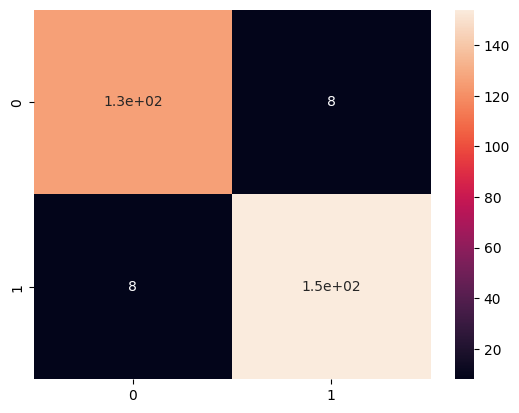

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       134
           1       0.95      0.95      0.95       162

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296

Best parameters for the original data:  {'C': 0.1}
Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


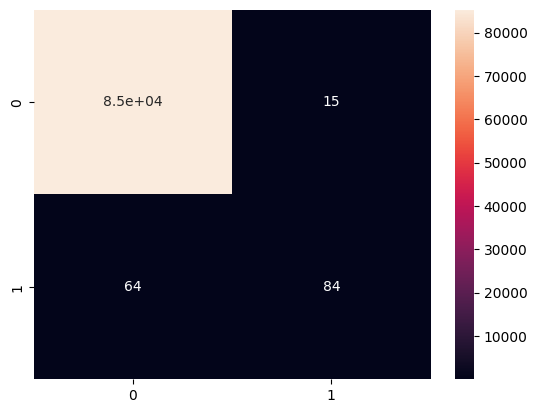

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.57      0.68       148

    accuracy                           1.00     85443
   macro avg       0.92      0.78      0.84     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score for original data : 0.9990754069964772


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model = LogisticRegression(max_iter=10000)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gs_up = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_up.fit(X_train_up, y_train_up.values.ravel())

print("Best parameters for the upsampled data: ", gs_up.best_params_)

model_up = LogisticRegression(C=gs_up.best_params_['C'], max_iter=10000)
model_up.fit(X_train_up, y_train_up.values.ravel())

y_pred_up = model_up.predict(X_test_up)

print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()

print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

gs_down = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_down.fit(X_train_down, y_train_down.values.ravel())

print("Best parameters for the downsampled data: ", gs_down.best_params_)

model_down = LogisticRegression(C=gs_down.best_params_['C'], max_iter=10000)
model_down.fit(X_train_down, y_train_down.values.ravel())

y_pred_down = model_down.predict(X_test_down)

print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()

print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

gs = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs.fit(X_train, y_train.values.ravel())

print("Best parameters for the original data: ", gs.best_params_)

model = LogisticRegression(C=gs.best_params_['C'], max_iter=10000)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()

print("Classification Report for the original data: \n", classification_report(y_test, y_pred))

print("Accuracy score for original data :", accuracy_score(y_test, y_pred))


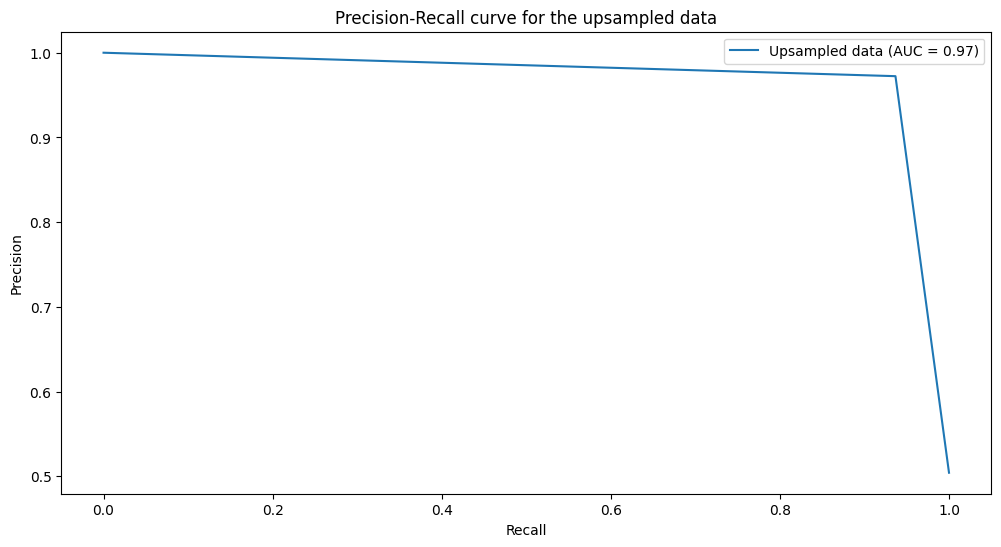

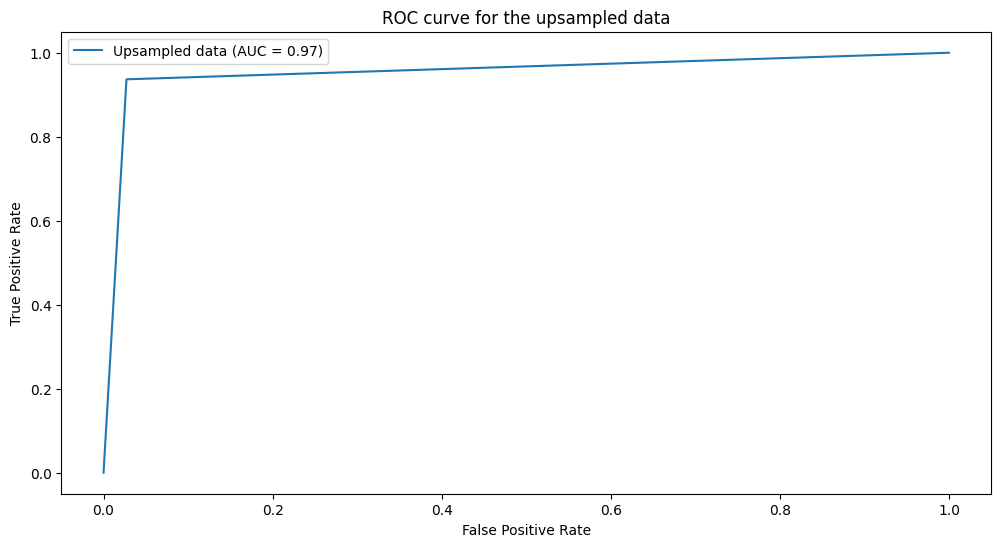

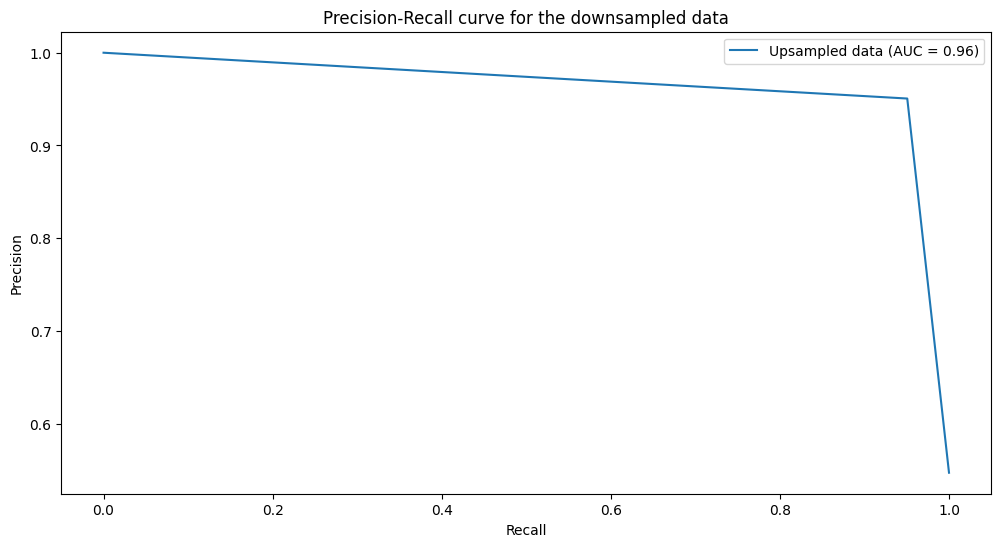

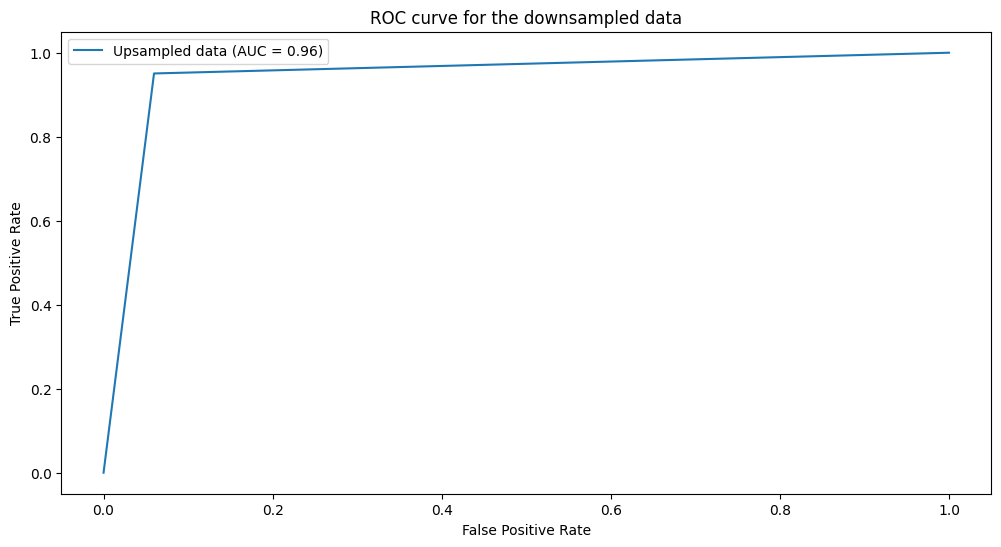

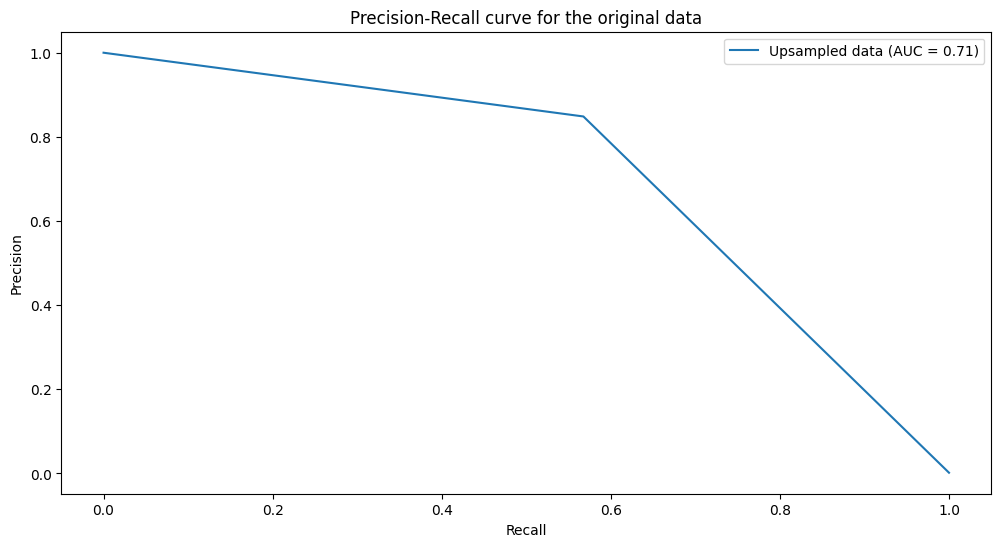

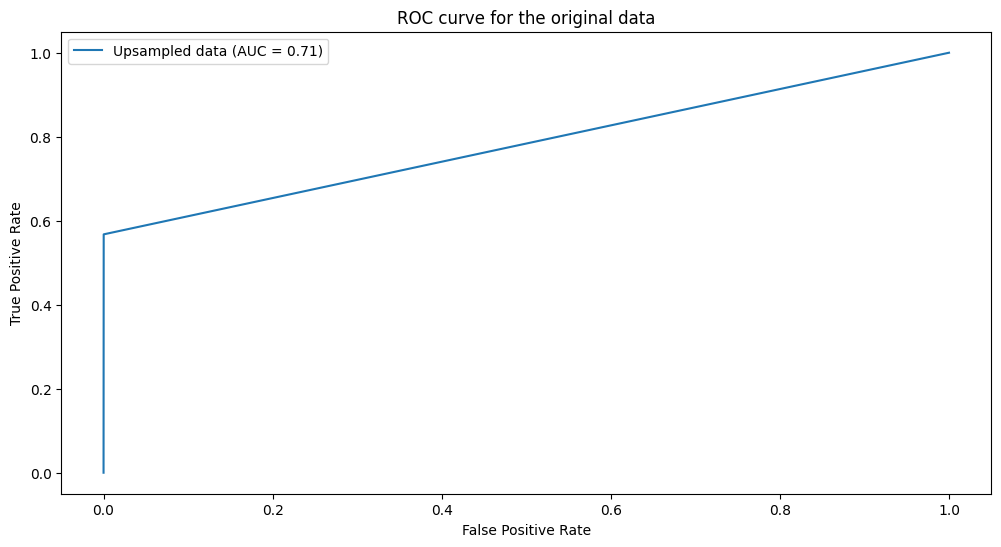

In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()



# KNN

Best parameters for the upsampled data:  {'n_neighbors': 5}
Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


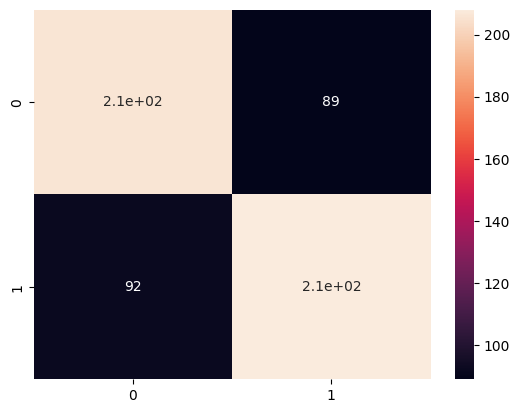

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.69      0.70      0.69       295
         1.0       0.70      0.69      0.70       300

    accuracy                           0.70       595
   macro avg       0.70      0.70      0.70       595
weighted avg       0.70      0.70      0.70       595

Best parameters for the downsampled data:  {'n_neighbors': 5}
Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


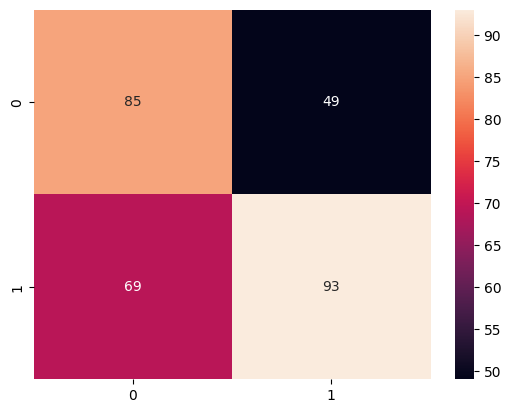

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.55      0.63      0.59       134
           1       0.65      0.57      0.61       162

    accuracy                           0.60       296
   macro avg       0.60      0.60      0.60       296
weighted avg       0.61      0.60      0.60       296

Best parameters for the original data:  {'n_neighbors': 1}
Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


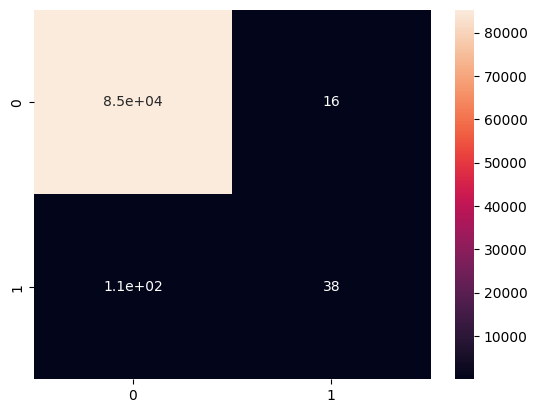

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.70      0.26      0.38       148

    accuracy                           1.00     85443
   macro avg       0.85      0.63      0.69     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score for original data : 0.9985253326779256


In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 3, 5]}

gs_up = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_up.fit(X_train_up, y_train_up.values.ravel())

print("Best parameters for the upsampled data: ", gs_up.best_params_)

model_up = KNeighborsClassifier(n_neighbors=gs_up.best_params_['n_neighbors'])
model_up.fit(X_train_up, y_train_up.values.ravel())

y_pred_up = model_up.predict(X_test_up)

print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()

print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

gs_down = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_down.fit(X_train_down, y_train_down.values.ravel())

print("Best parameters for the downsampled data: ", gs_down.best_params_)

model_down = KNeighborsClassifier(n_neighbors=gs_down.best_params_['n_neighbors'])
model_down.fit(X_train_down, y_train_down.values.ravel())

y_pred_down = model_down.predict(X_test_down)

print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()

print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

gs = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs.fit(X_train, y_train.values.ravel())

print("Best parameters for the original data: ", gs.best_params_)

model = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'])
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()

print("Classification Report for the original data: \n", classification_report(y_test, y_pred))

print("Accuracy score for original data :", accuracy_score(y_test, y_pred))



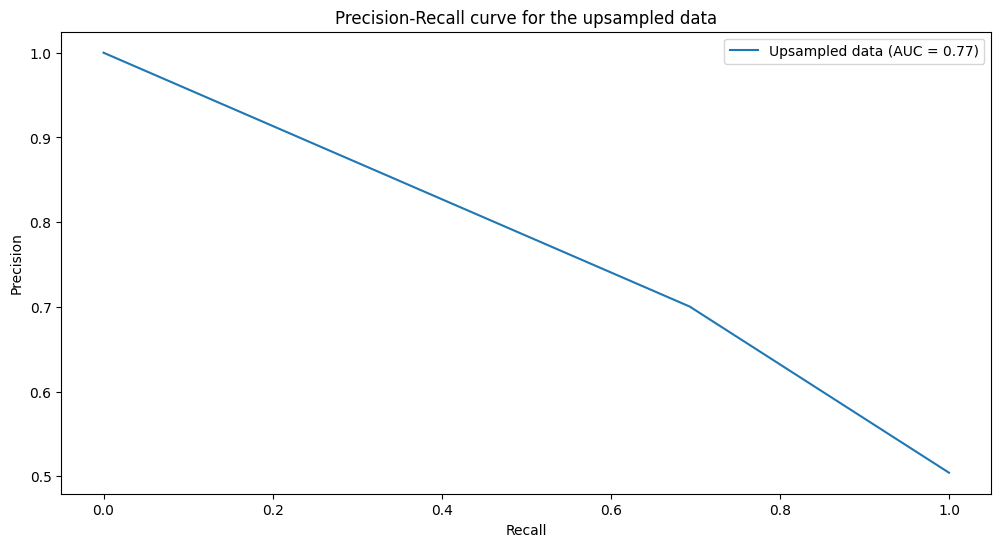

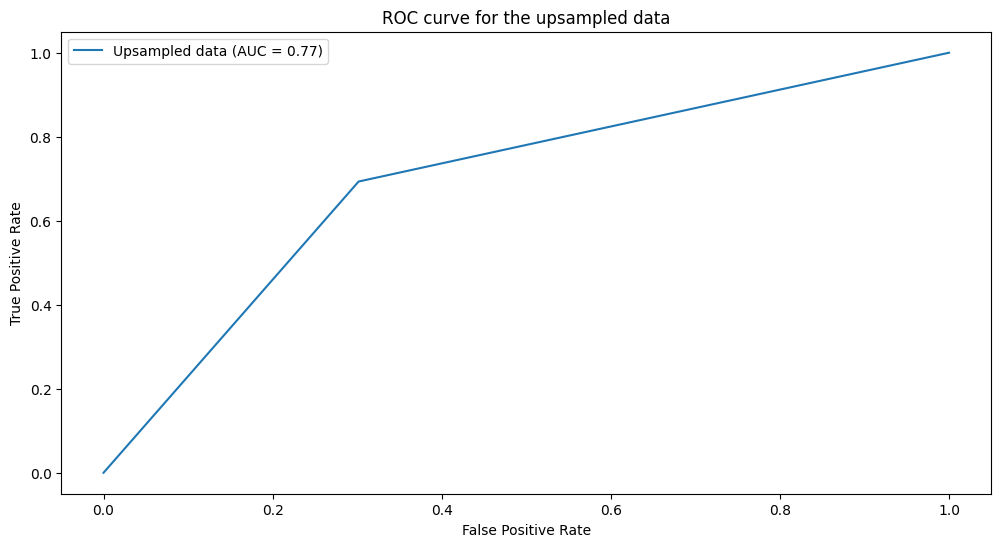

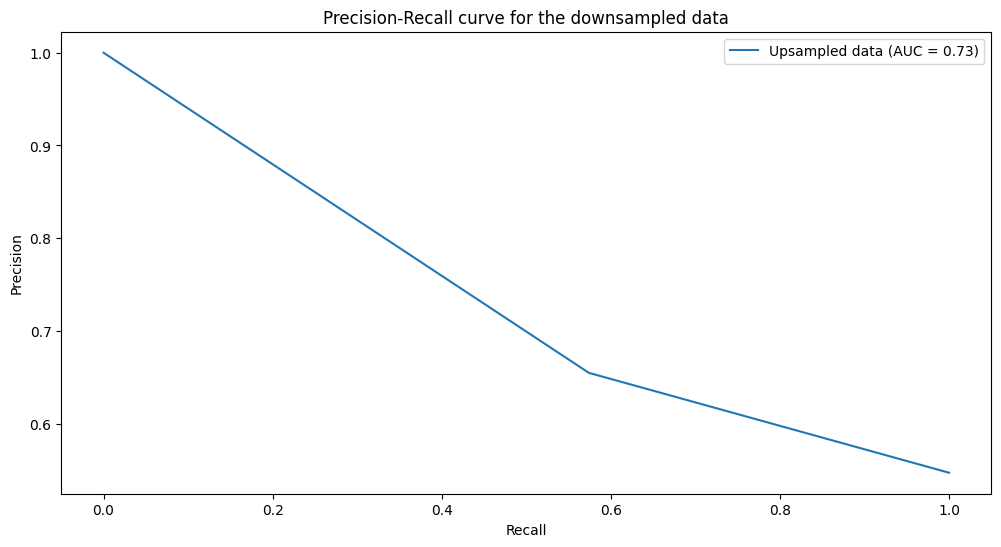

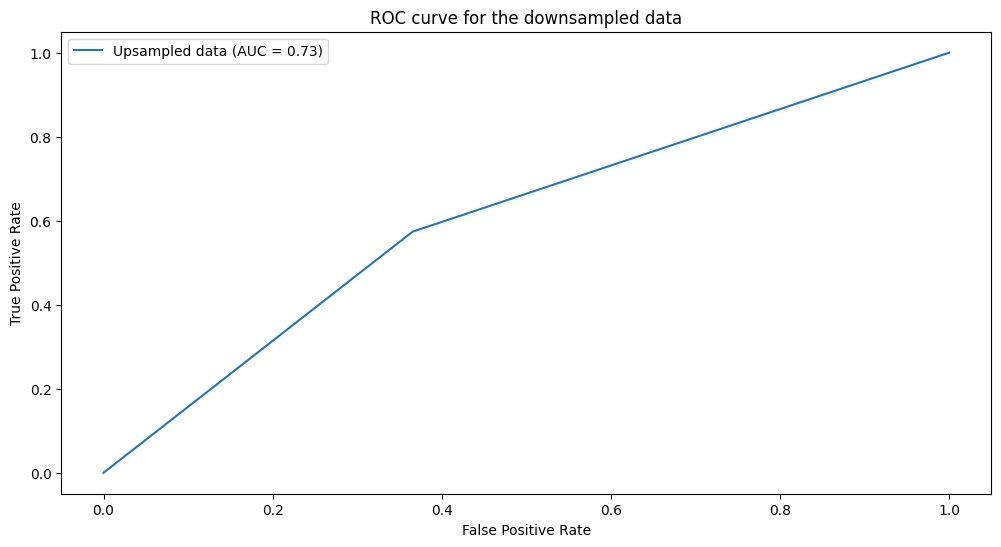

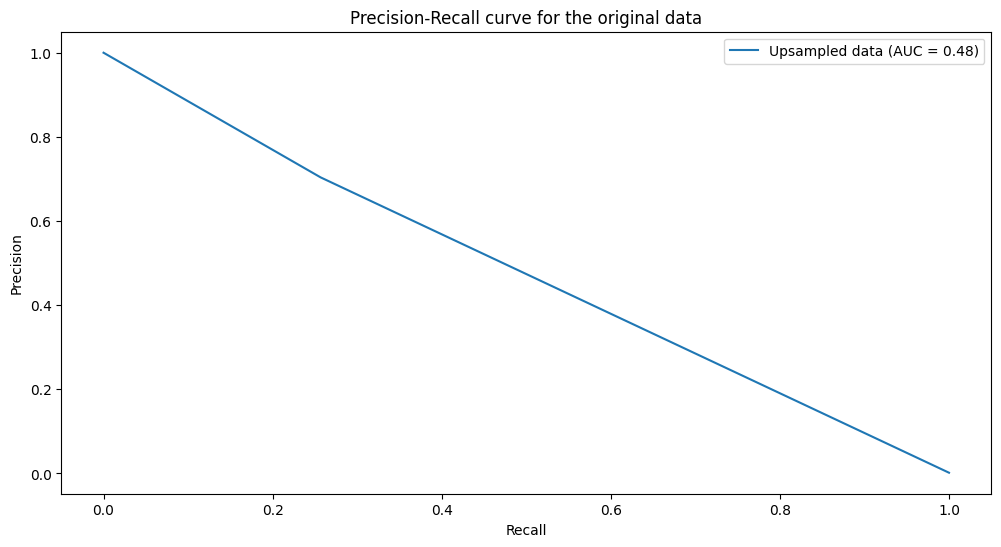

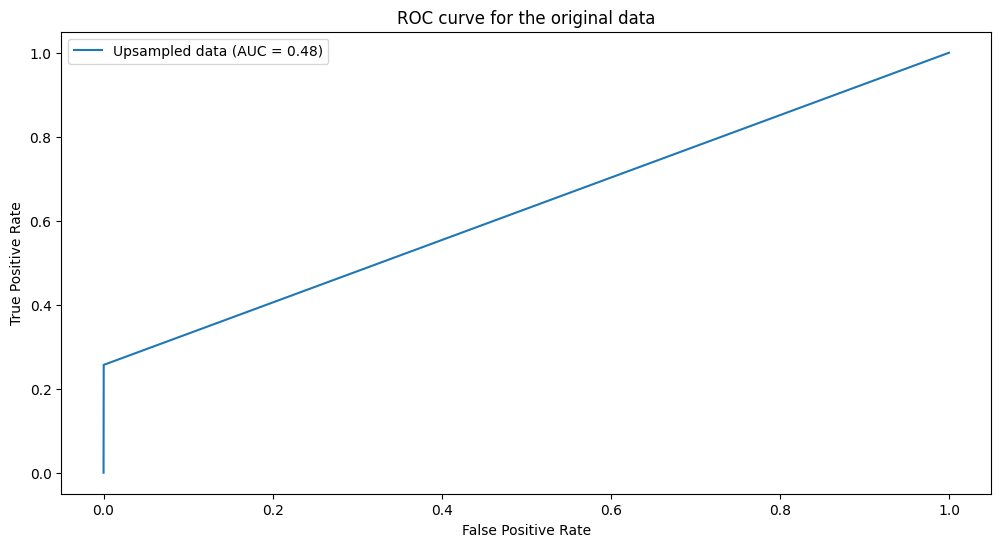

In [14]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()



# SVM

Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


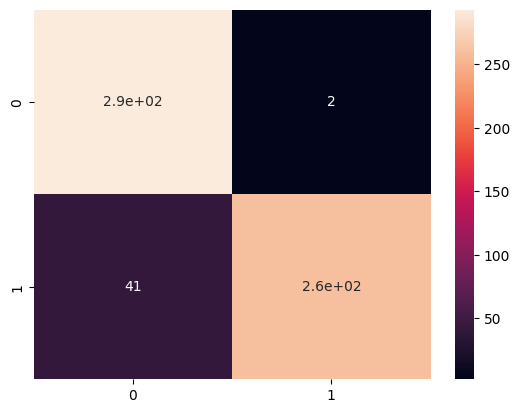

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       295
         1.0       0.99      0.86      0.92       300

    accuracy                           0.93       595
   macro avg       0.93      0.93      0.93       595
weighted avg       0.94      0.93      0.93       595

Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


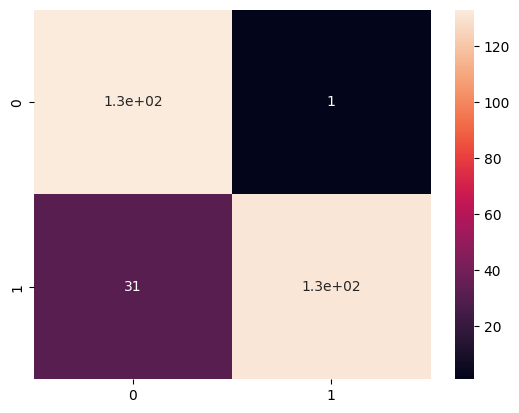

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       134
           1       0.99      0.81      0.89       162

    accuracy                           0.89       296
   macro avg       0.90      0.90      0.89       296
weighted avg       0.91      0.89      0.89       296

Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


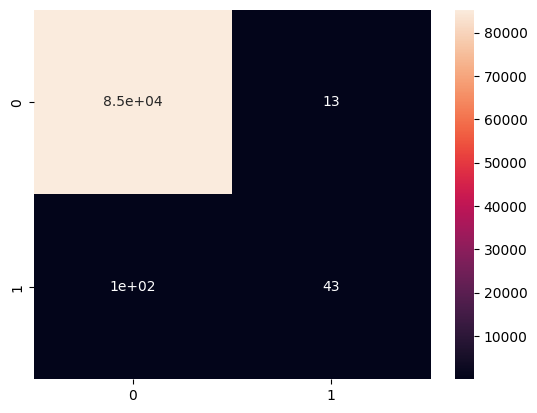

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.77      0.29      0.42       148

    accuracy                           1.00     85443
   macro avg       0.88      0.65      0.71     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score for original data : 0.9986189623491685


In [15]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

model_up = SVC(kernel='linear')
model_up.fit(X_train_up, y_train_up.values.ravel())

y_pred_up = model_up.predict(X_test_up)

print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()

print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

model_down = SVC(kernel='linear')
model_down.fit(X_train_down, y_train_down.values.ravel())

y_pred_down = model_down.predict(X_test_down)

print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()

print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

model = SVC(kernel='linear')
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()

print("Classification Report for the original data: \n", classification_report(y_test, y_pred))

print("Accuracy score for original data :", accuracy_score(y_test, y_pred))

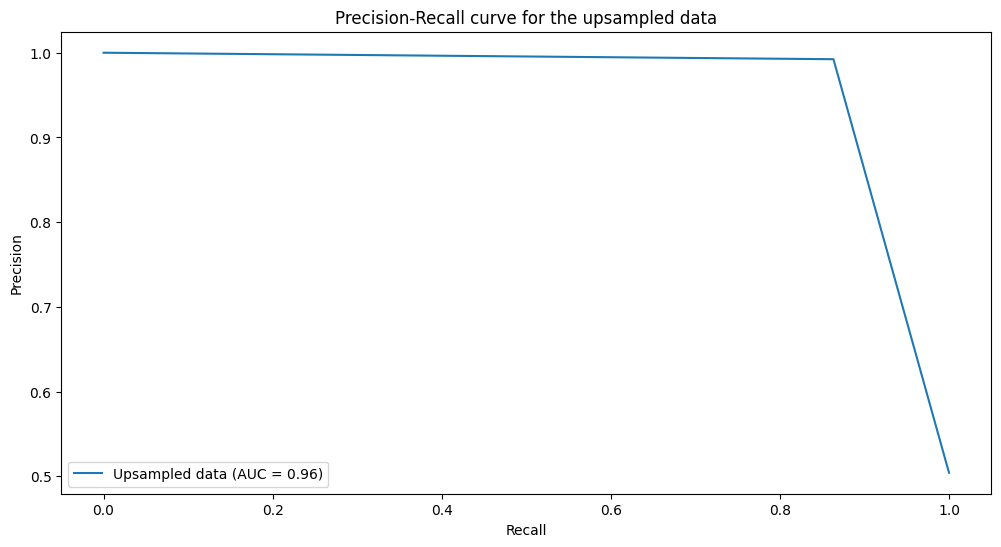

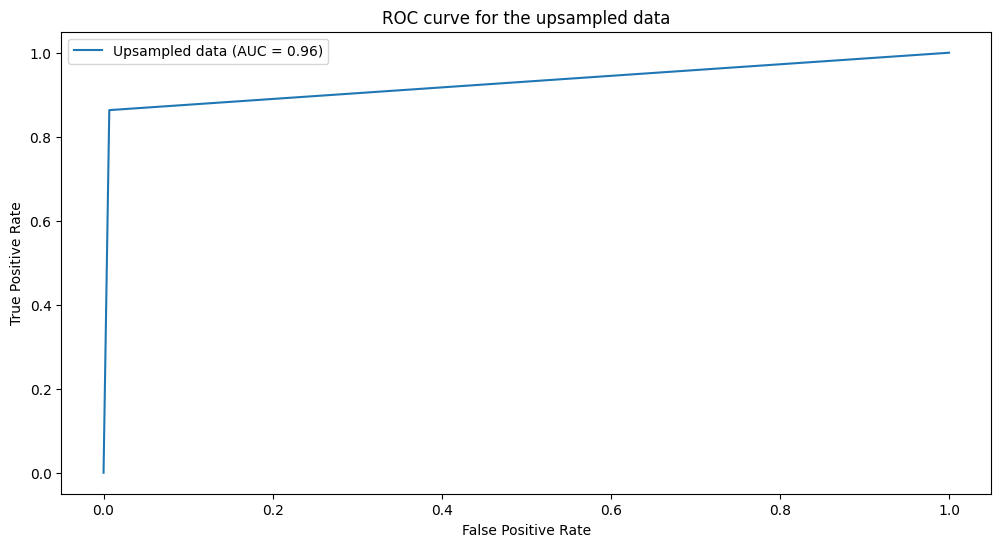

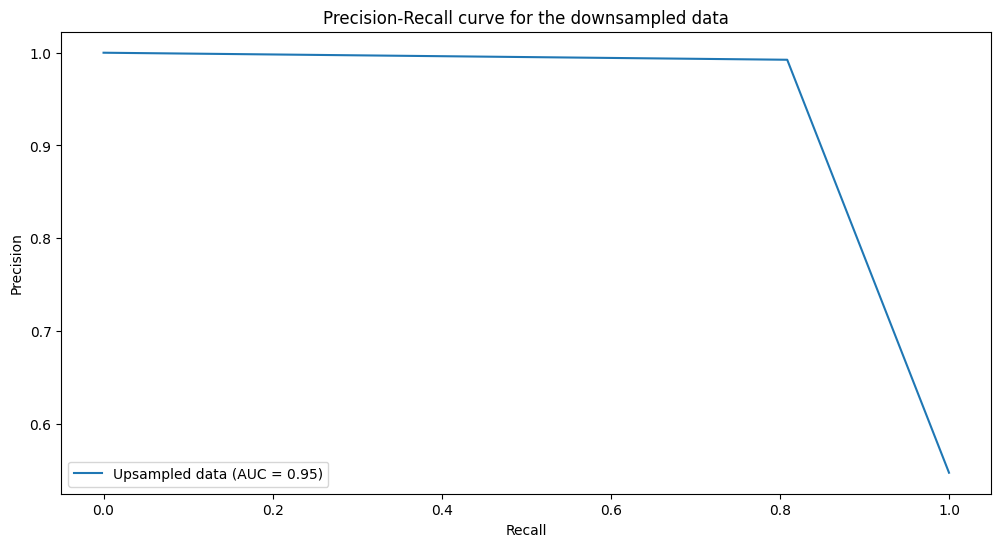

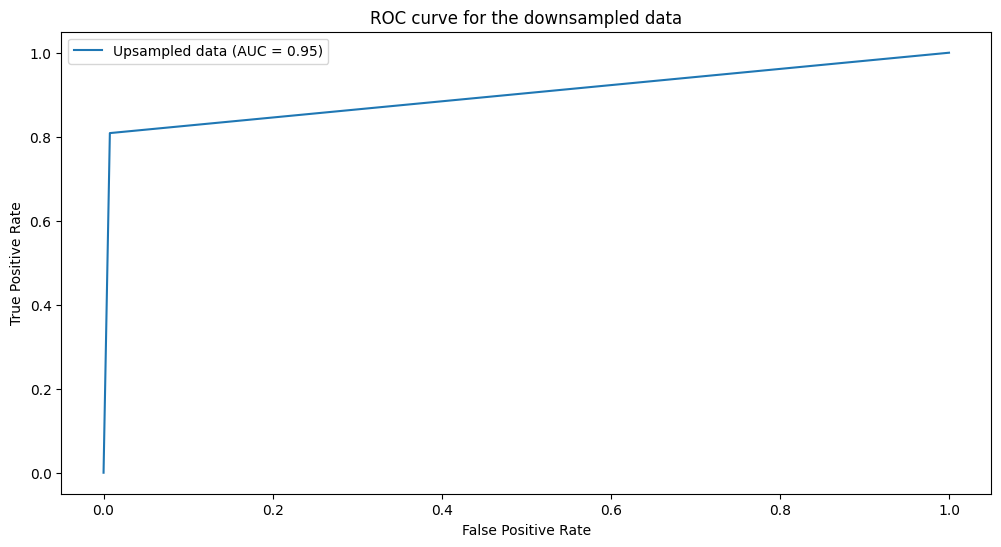

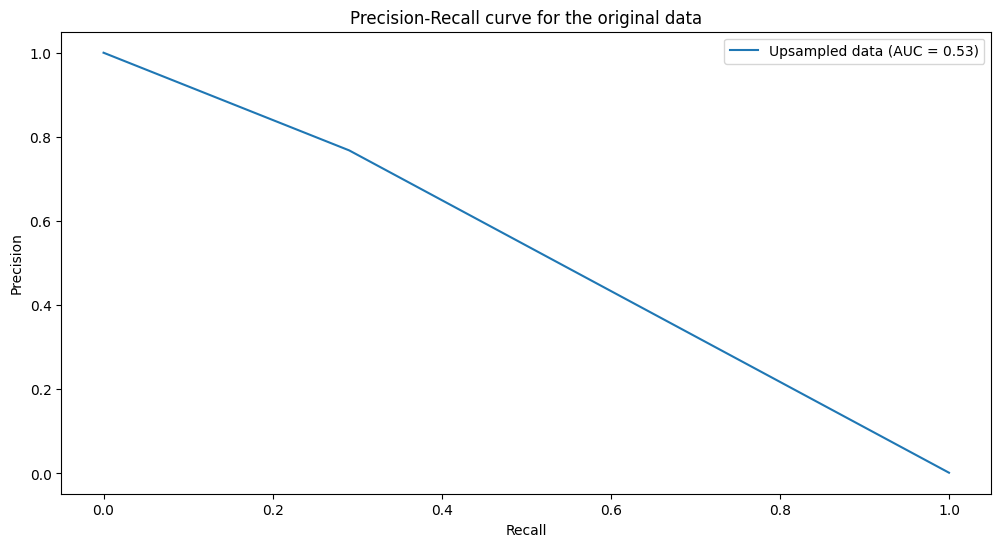

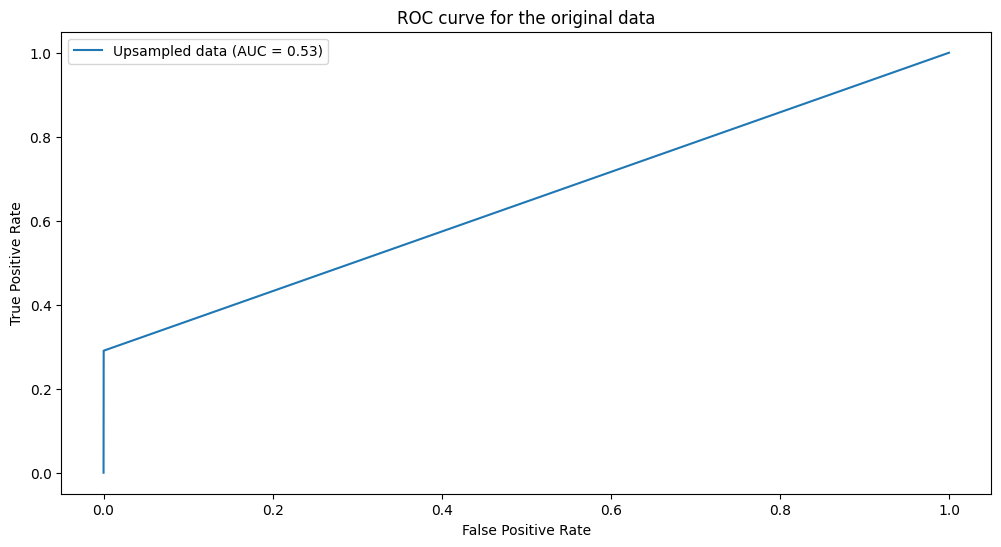

In [16]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()

# Decision Tree

Best parameters for the upsampled data:  {'max_depth': 5, 'min_samples_split': 5}
Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


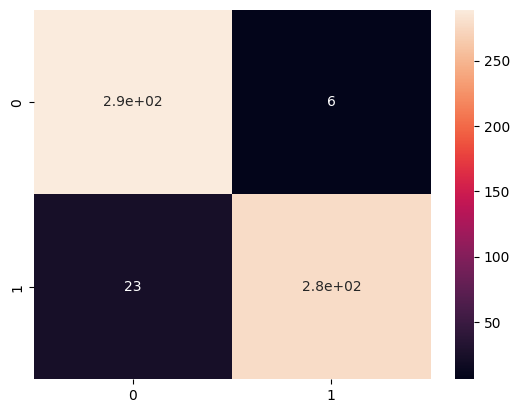

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       295
         1.0       0.98      0.92      0.95       300

    accuracy                           0.95       595
   macro avg       0.95      0.95      0.95       595
weighted avg       0.95      0.95      0.95       595

Best parameters for the downsampled data:  {'max_depth': 5, 'min_samples_split': 5}
Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


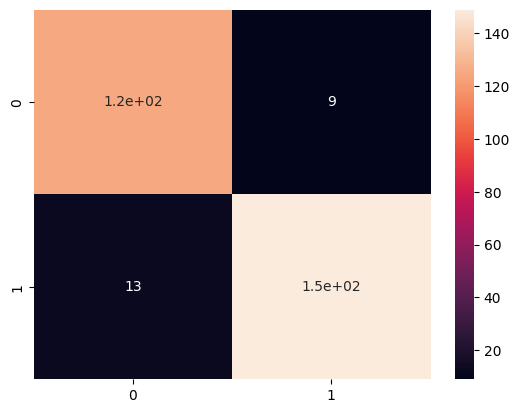

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       134
           1       0.94      0.92      0.93       162

    accuracy                           0.93       296
   macro avg       0.92      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Best parameters for the original data:  {'max_depth': 5, 'min_samples_split': 2}
Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


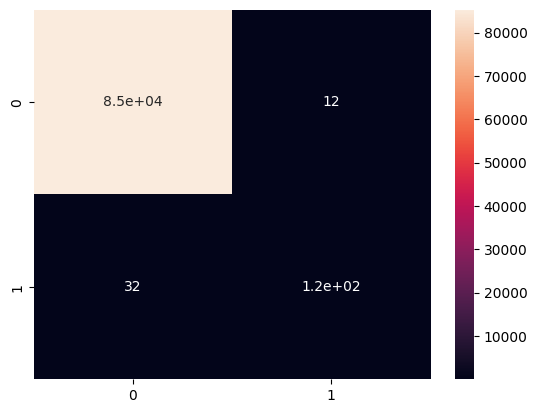

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.78      0.84       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score for original data : 0.9994850368081645


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define the model
model = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {'max_depth': [None, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for upsampled data
gs_up = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_up.fit(X_train_up, y_train_up.values.ravel())
print("Best parameters for the upsampled data: ", gs_up.best_params_)

# Fit and predict with the best model
model_up = DecisionTreeClassifier(**gs_up.best_params_)
model_up.fit(X_train_up, y_train_up.values.ravel())
y_pred_up = model_up.predict(X_test_up)

# Print metrics
print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()
print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

gs_down = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_down.fit(X_train_down, y_train_down.values.ravel())

print("Best parameters for the downsampled data: ", gs_down.best_params_)

model_down = DecisionTreeClassifier(**gs_down.best_params_)
model_down.fit(X_train_down, y_train_down.values.ravel())

y_pred_down = model_down.predict(X_test_down)

print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()

print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

gs = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs.fit(X_train, y_train.values.ravel())

print("Best parameters for the original data: ", gs.best_params_)

model = DecisionTreeClassifier(**gs.best_params_)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()

print("Classification Report for the original data: \n", classification_report(y_test, y_pred))

print("Accuracy score for original data :", accuracy_score(y_test, y_pred))

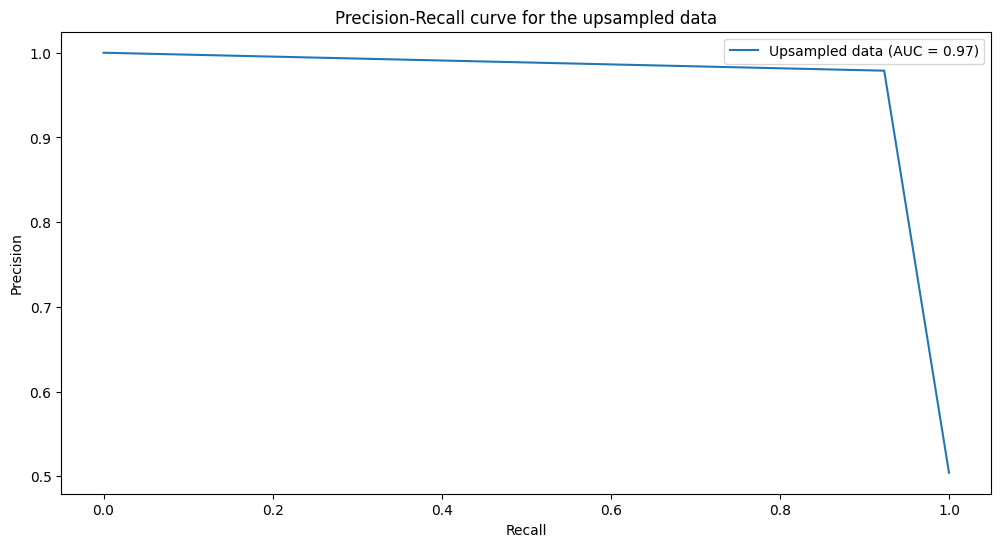

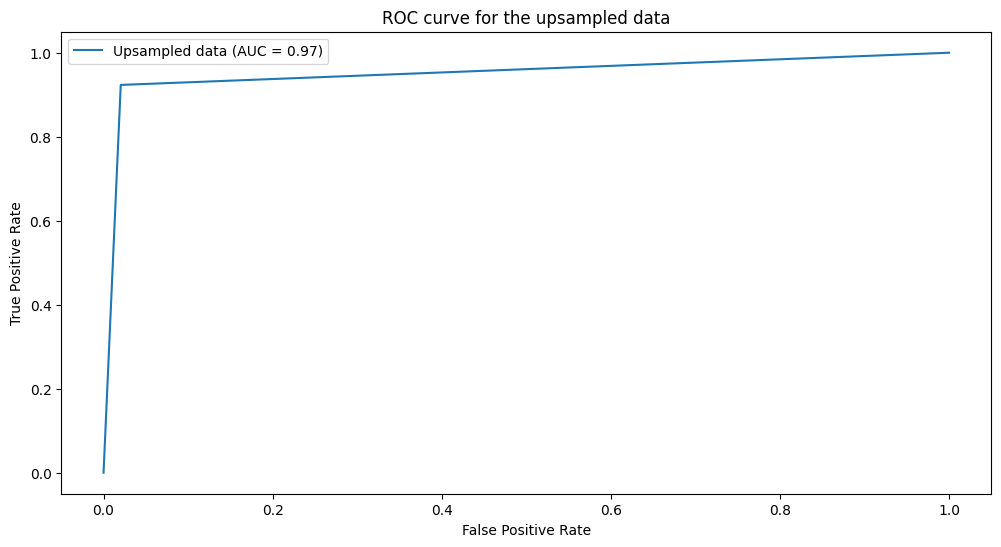

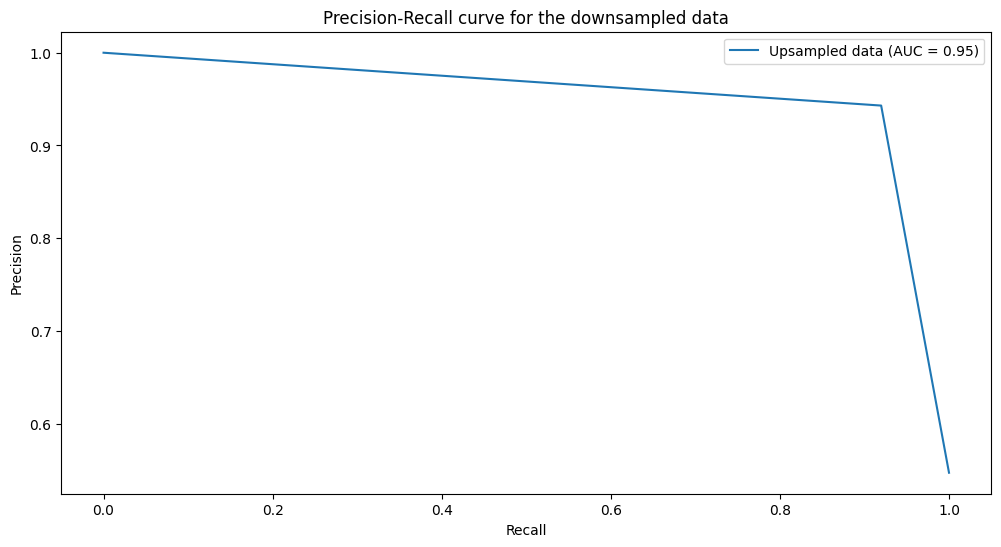

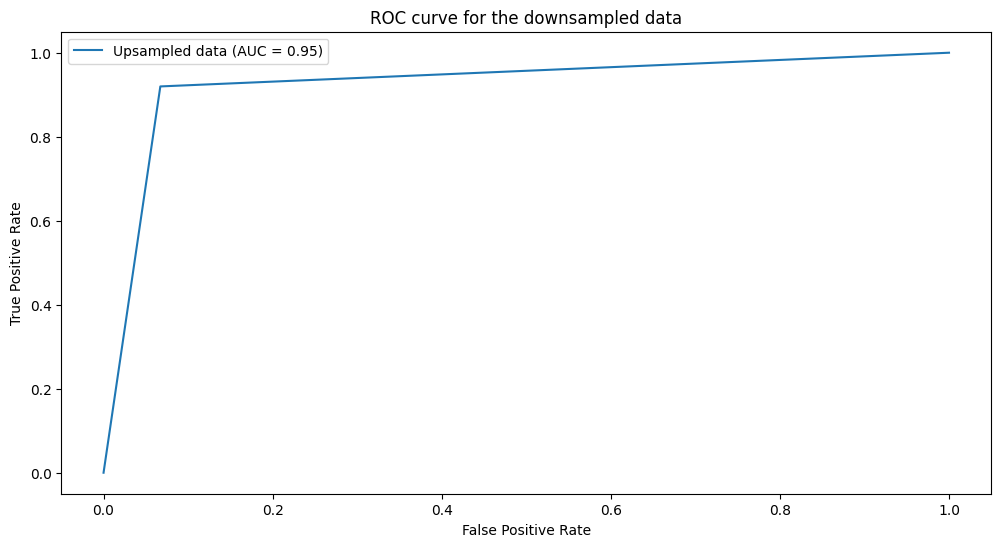

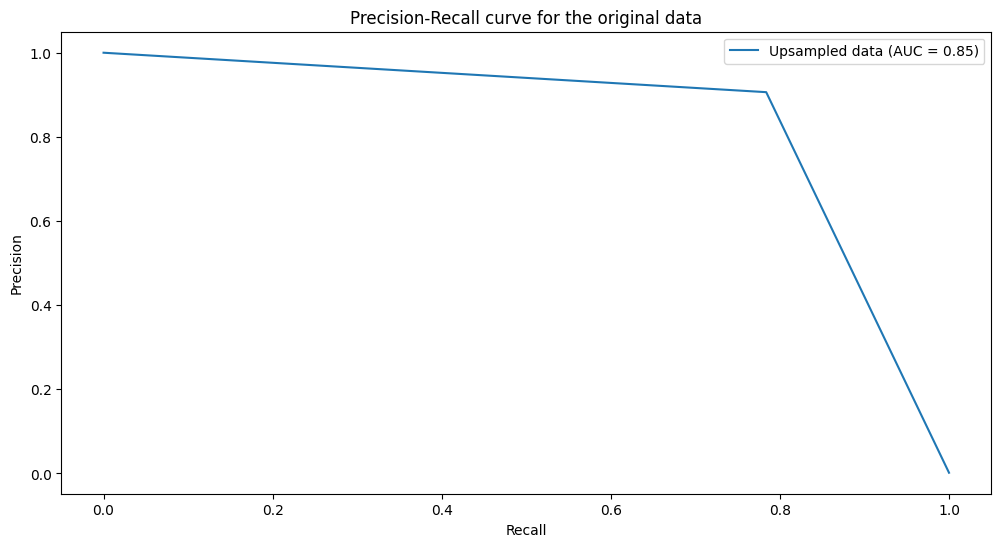

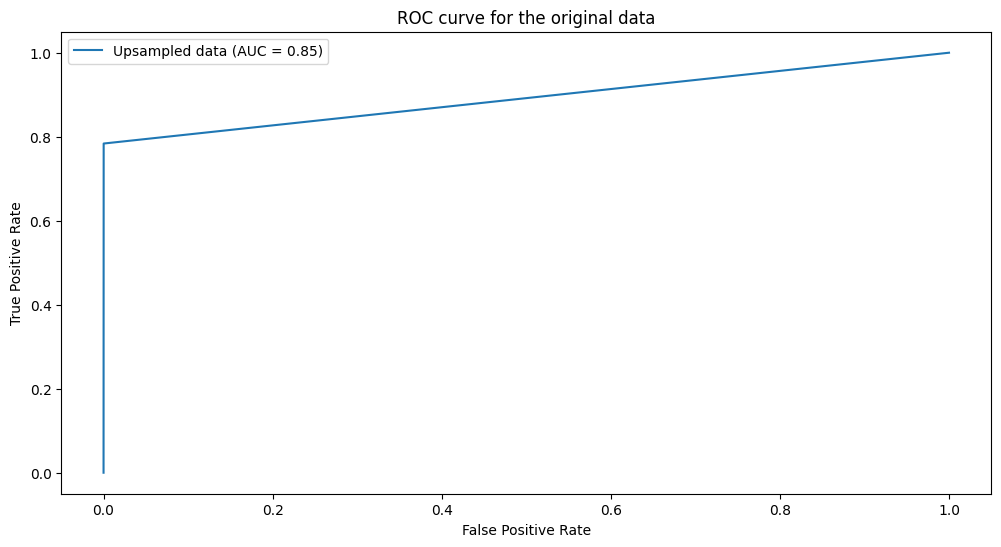

In [18]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()

# Random Forest

Best parameters for the upsampled data:  {'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


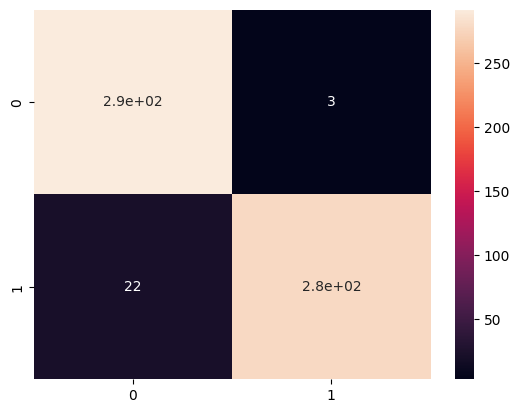

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       295
         1.0       0.99      0.93      0.96       300

    accuracy                           0.96       595
   macro avg       0.96      0.96      0.96       595
weighted avg       0.96      0.96      0.96       595

Best parameters for the downsampled data:  {'min_samples_split': 5, 'n_estimators': 100}
Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


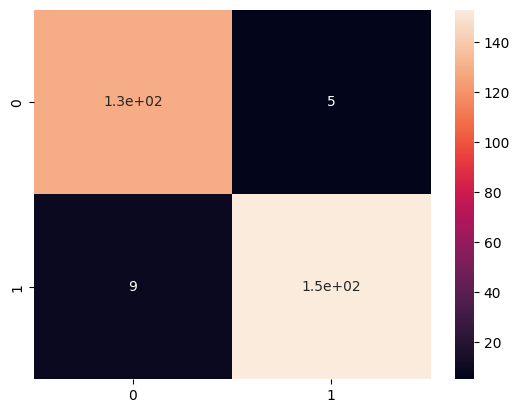

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       134
           1       0.97      0.94      0.96       162

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296

Best parameters for the original data:  {'min_samples_split': 5, 'n_estimators': 200}
Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


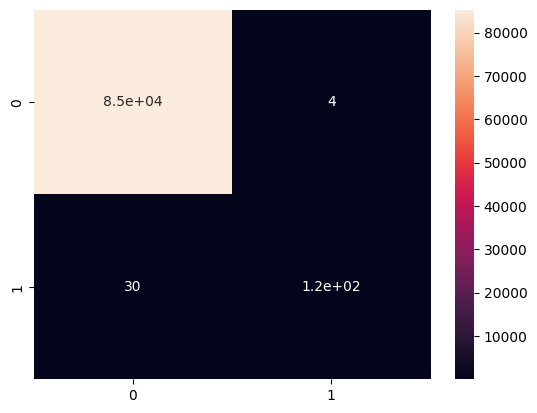

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.80      0.87       148

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score for original data : 0.999602073897218


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define the model
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {'n_estimators': [100, 200], 'min_samples_split': [2, 5]}

# GridSearchCV for upsampled data
gs_up = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_up.fit(X_train_up, y_train_up.values.ravel())
print("Best parameters for the upsampled data: ", gs_up.best_params_)

# Fit and predict with the best model
model_up = RandomForestClassifier(**gs_up.best_params_)
model_up.fit(X_train_up, y_train_up.values.ravel())
y_pred_up = model_up.predict(X_test_up)

# Print metrics
print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()
print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

gs_down = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs_down.fit(X_train_down, y_train_down.values.ravel())

print("Best parameters for the downsampled data: ", gs_down.best_params_)

model_down = RandomForestClassifier(**gs_down.best_params_)
model_down.fit(X_train_down, y_train_down.values.ravel())

y_pred_down = model_down.predict(X_test_down)

print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()

print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

gs = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=0)
gs.fit(X_train, y_train.values.ravel())

print("Best parameters for the original data: ", gs.best_params_)

model = RandomForestClassifier(**gs.best_params_)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()

print("Classification Report for the original data: \n", classification_report(y_test, y_pred))

print("Accuracy score for original data :", accuracy_score(y_test, y_pred))



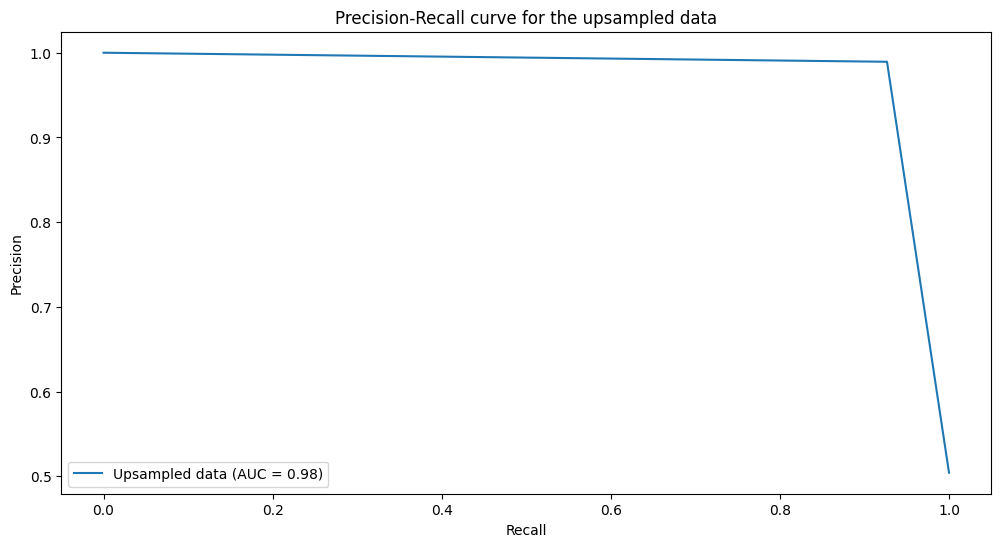

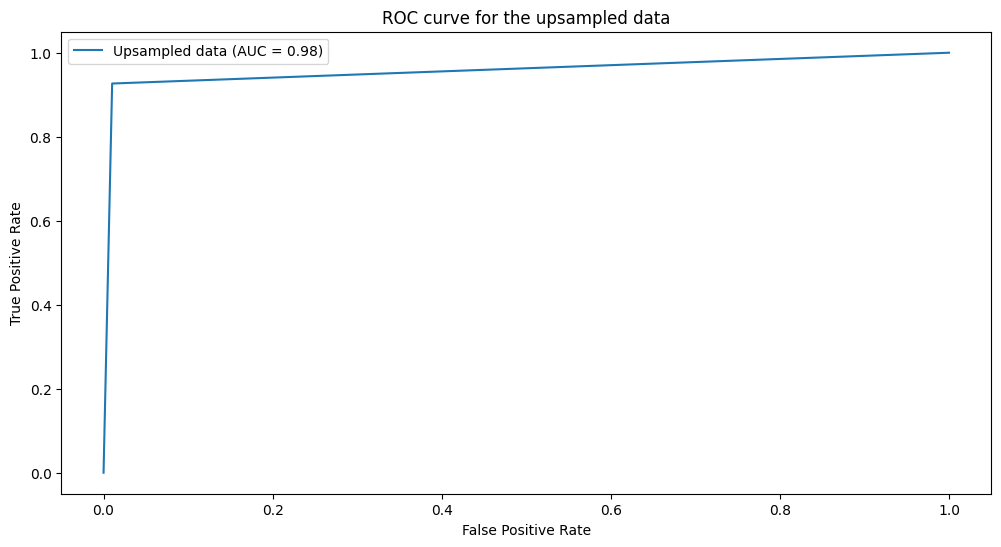

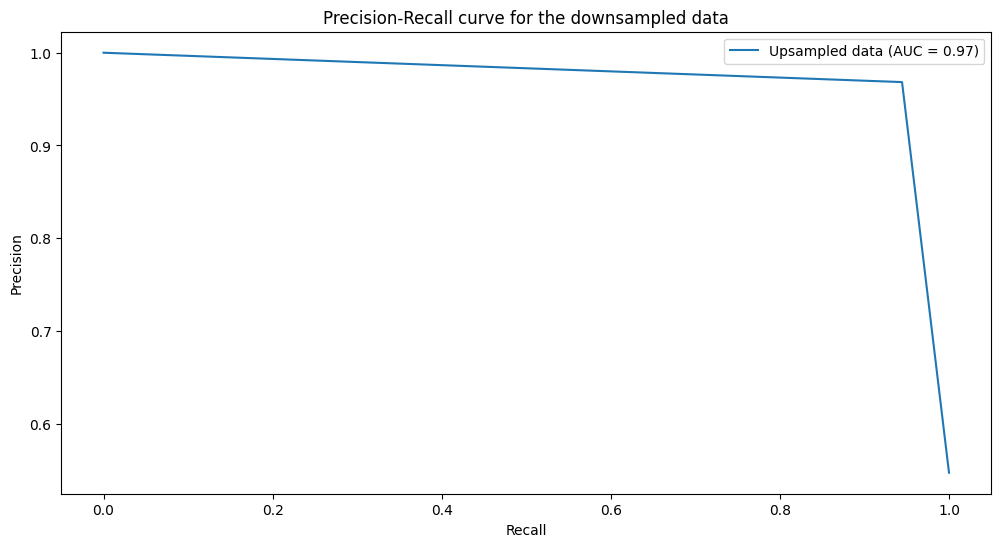

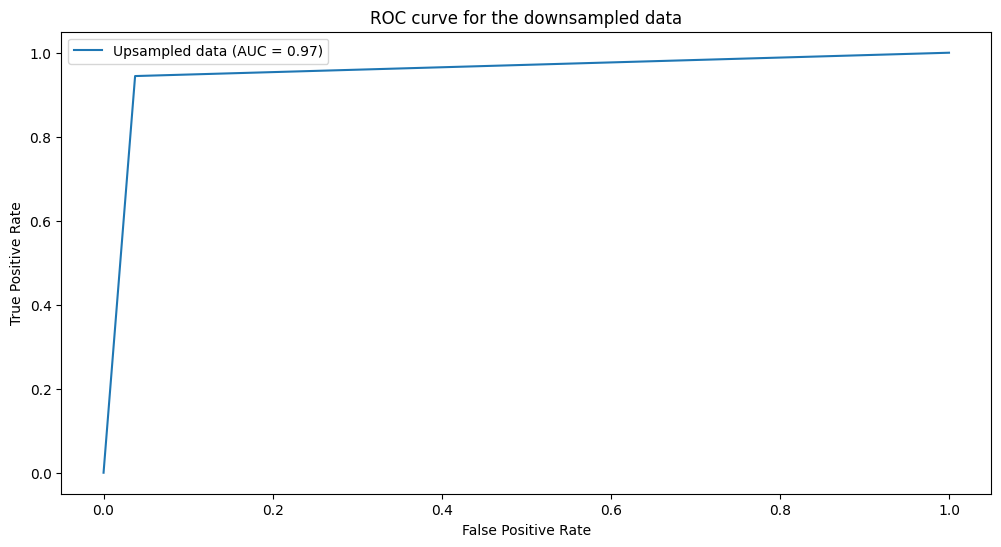

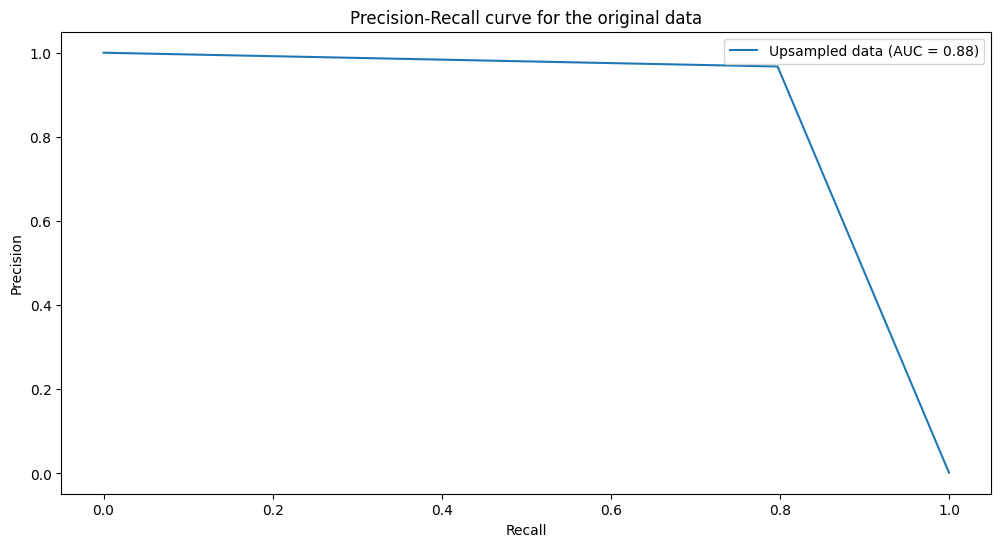

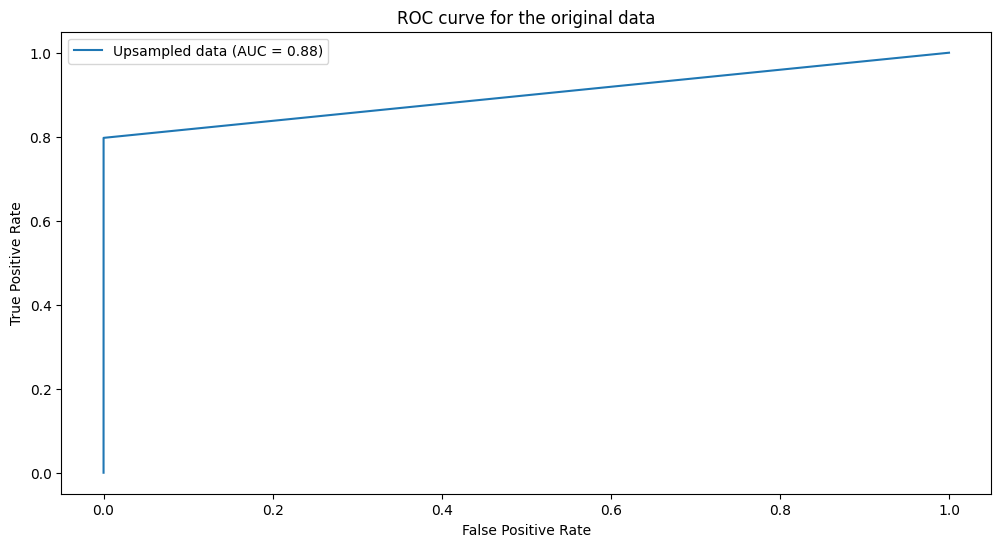

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()



# ANN

Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


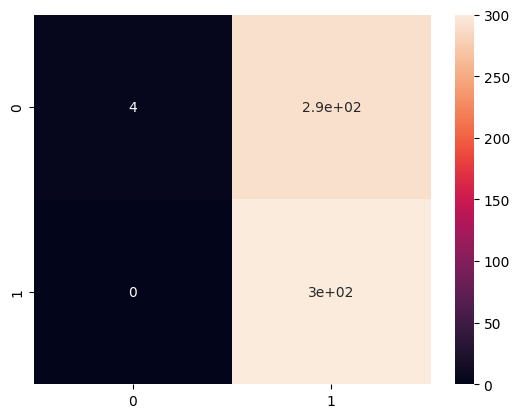

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.03       295
         1.0       0.51      1.00      0.67       300

    accuracy                           0.51       595
   macro avg       0.75      0.51      0.35       595
weighted avg       0.75      0.51      0.35       595

Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


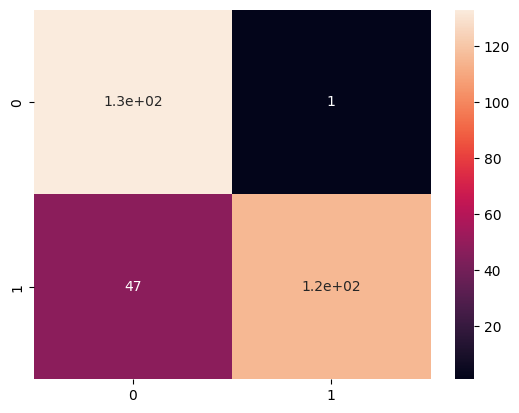

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.74      0.99      0.85       134
           1       0.99      0.71      0.83       162

    accuracy                           0.84       296
   macro avg       0.87      0.85      0.84       296
weighted avg       0.88      0.84      0.84       296

Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


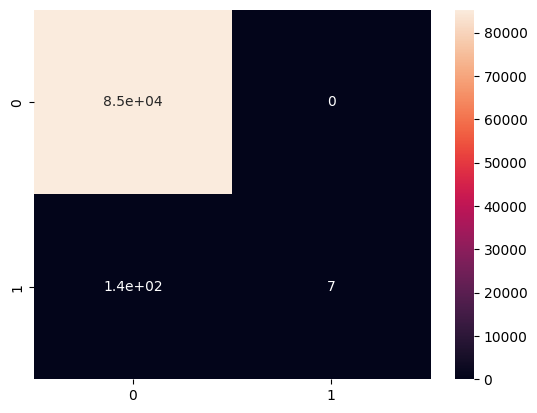

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      0.05      0.09       148

    accuracy                           1.00     85443
   macro avg       1.00      0.52      0.54     85443
weighted avg       1.00      1.00      1.00     85443



In [22]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Function to create model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=30, activation='relu'))  # Change here #relu is used in hidden layers (0,x)
    model.add(Dense(1, activation='sigmoid'))  #sigmoid is used in output layers (0,1)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Create and fit the model with the specified parameters
model_up = create_model()
model_up.fit(X_train_up, y_train_up.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred_up = model_up.predict(X_test_up)

y_pred_up_proba = model_up.predict(X_test_up)
y_pred_up = (y_pred_up_proba > 0.5).astype(int)

# Print metrics for upsampled data
print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()
print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

# Create and fit the model with the specified parameters for downsampled data
model_down = create_model()
model_down.fit(X_train_down, y_train_down.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred_down = model_down.predict(X_test_down)

y_pred_down_proba = model_down.predict(X_test_down)
y_pred_down = (y_pred_down_proba > 0.5).astype(int)

# Print metrics for downsampled data
print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()
print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

# Create and fit the model with the specified parameters for original data
model = create_model()
model.fit(X_train, y_train.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred = model.predict(X_test)

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Print metrics for original data
print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()
print("Classification Report for the original data: \n", classification_report(y_test, y_pred))


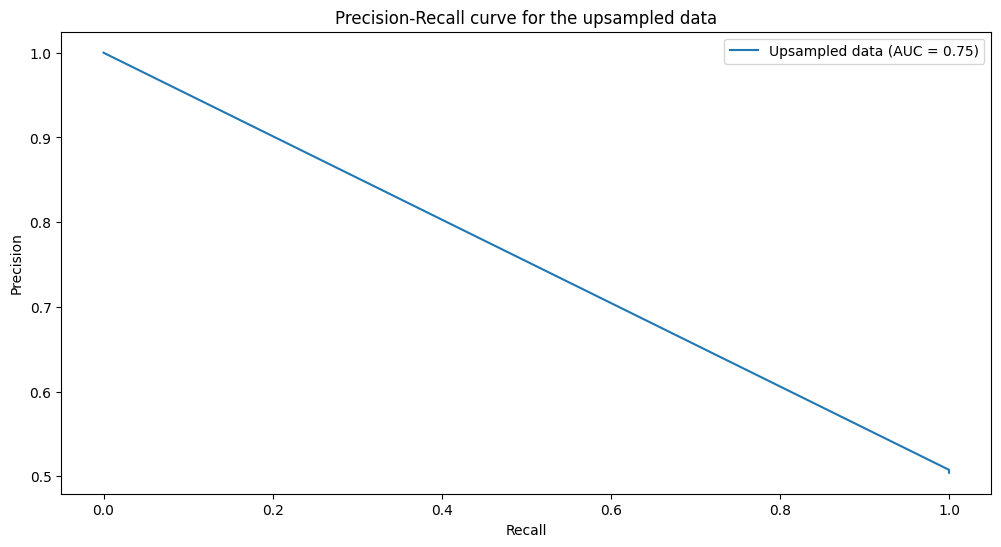

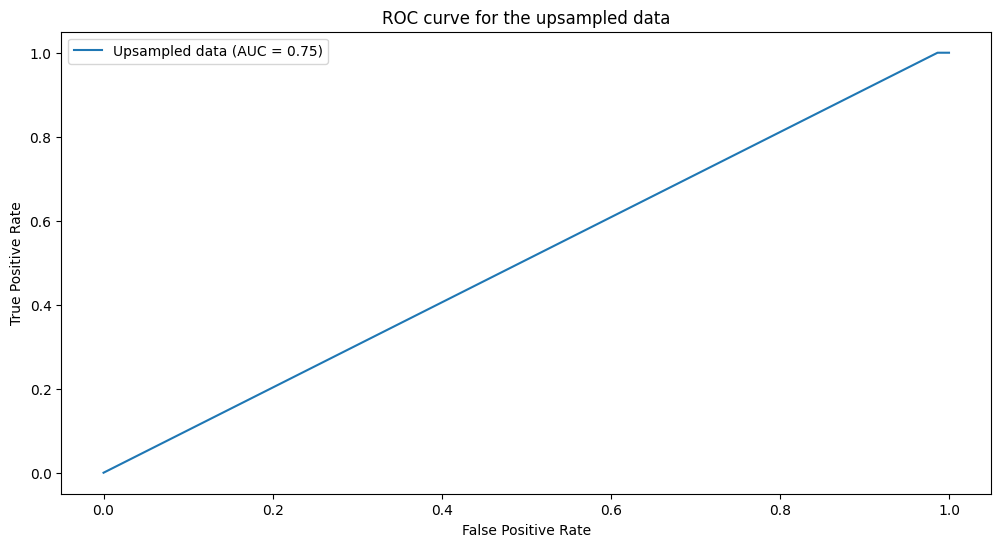

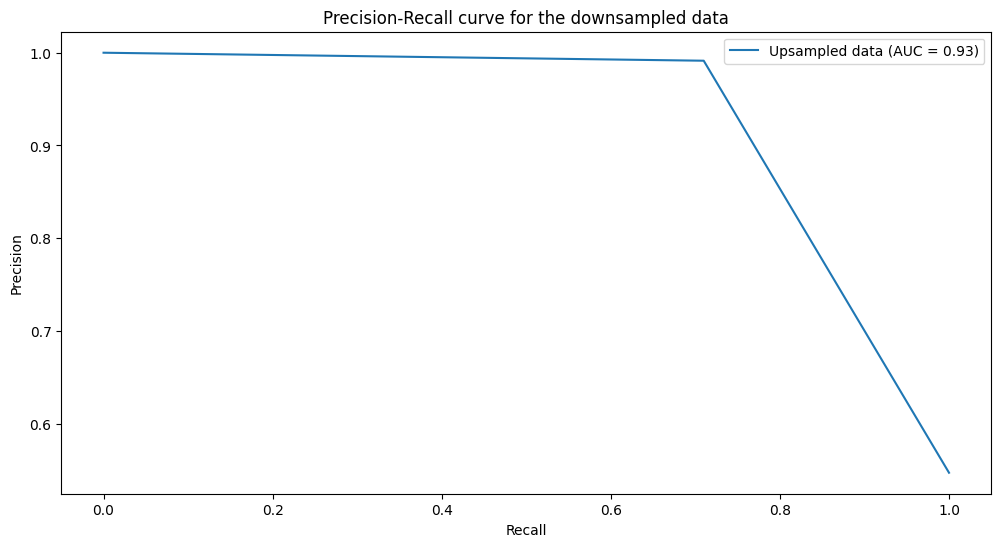

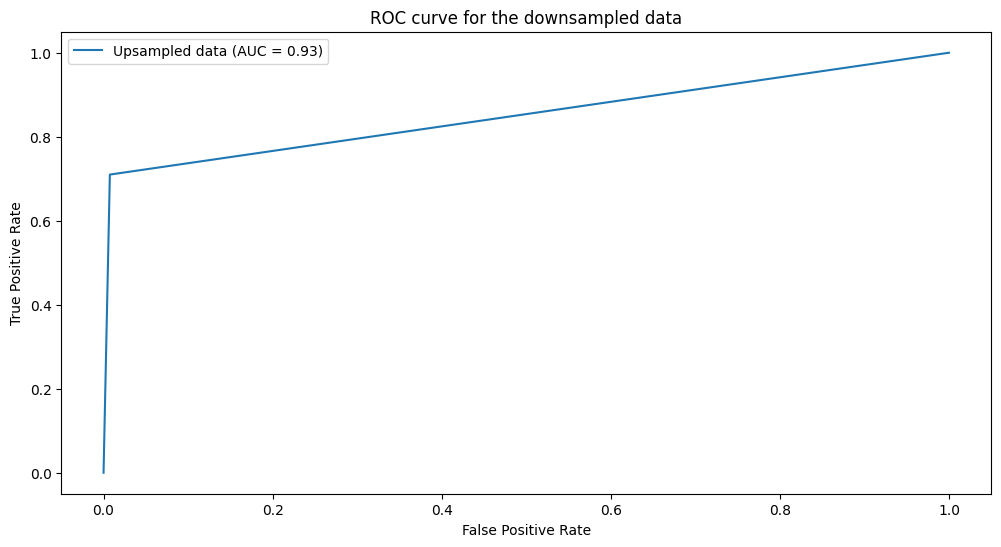

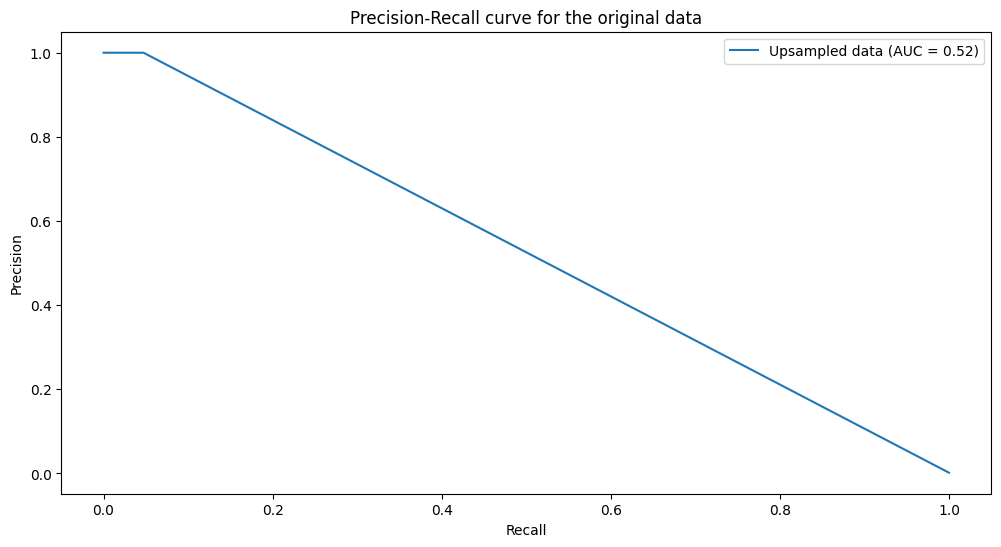

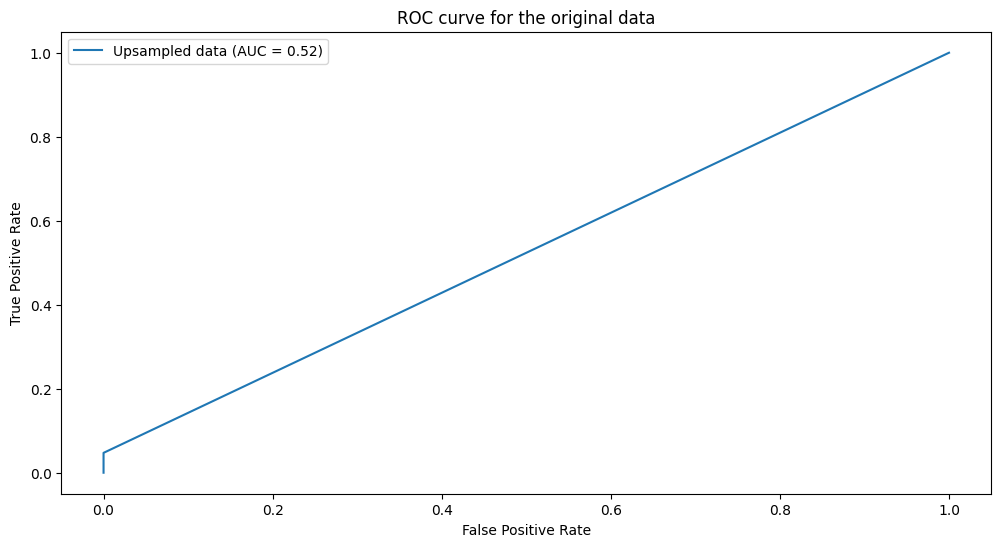

In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()


# CNN

Confusion Matrix for the upsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


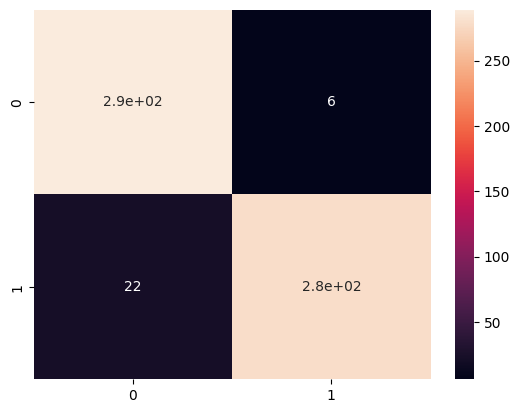

Classification Report for the upsampled data: 
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       295
         1.0       0.98      0.93      0.95       300

    accuracy                           0.95       595
   macro avg       0.95      0.95      0.95       595
weighted avg       0.95      0.95      0.95       595

Confusion Matrix for the downsampled data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


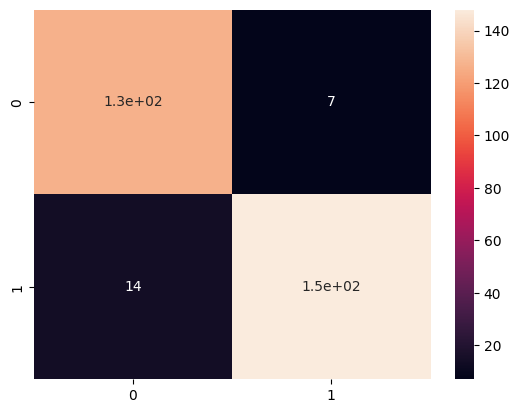

Classification Report for the downsampled data: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       134
           1       0.95      0.91      0.93       162

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Confusion Matrix for the original data: 
 AxesSubplot(0.125,0.11;0.62x0.77)


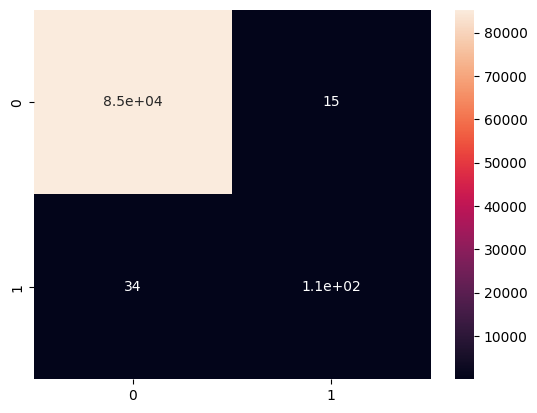

Classification Report for the original data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.77      0.82       148

    accuracy                           1.00     85443
   macro avg       0.94      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Function to create model
def create_model():
    # create model
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(30, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Reshape data
X_train_up = X_train_up.values.reshape(-1, 30, 1)
X_test_up = X_test_up.values.reshape(-1, 30, 1)

# Create and fit the model with the specified parameters
model_up = create_model()
model_up.fit(X_train_up, y_train_up.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred_up = (model_up.predict(X_test_up) > 0.5).astype(int)

# Print metrics for upsampled data
print("Confusion Matrix for the upsampled data: \n", sns.heatmap(confusion_matrix(y_test_up, y_pred_up), annot=True))
plt.show()
print("Classification Report for the upsampled data: \n", classification_report(y_test_up, y_pred_up))

# Reshape data
X_train_down = X_train_down.values.reshape(-1, 30, 1)
X_test_down = X_test_down.values.reshape(-1, 30, 1)

# Create and fit the model with the specified parameters for downsampled data
model_down = create_model()
model_down.fit(X_train_down, y_train_down.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred_down = (model_down.predict(X_test_down) > 0.5).astype(int)

# Print metrics for downsampled data
print("Confusion Matrix for the downsampled data: \n", sns.heatmap(confusion_matrix(y_test_down, y_pred_down), annot=True))
plt.show()
print("Classification Report for the downsampled data: \n", classification_report(y_test_down, y_pred_down))

# Reshape data
X_train = X_train.values.reshape(-1, 30, 1)
X_test = X_test.values.reshape(-1, 30, 1)

# Create and fit the model with the specified parameters for original data
model = create_model()
model.fit(X_train, y_train.values.ravel(), epochs=50, batch_size=32, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print metrics for original data
print("Confusion Matrix for the original data: \n", sns.heatmap(confusion_matrix(y_test, y_pred), annot=True))
plt.show()
print("Classification Report for the original data: \n", classification_report(y_test, y_pred))


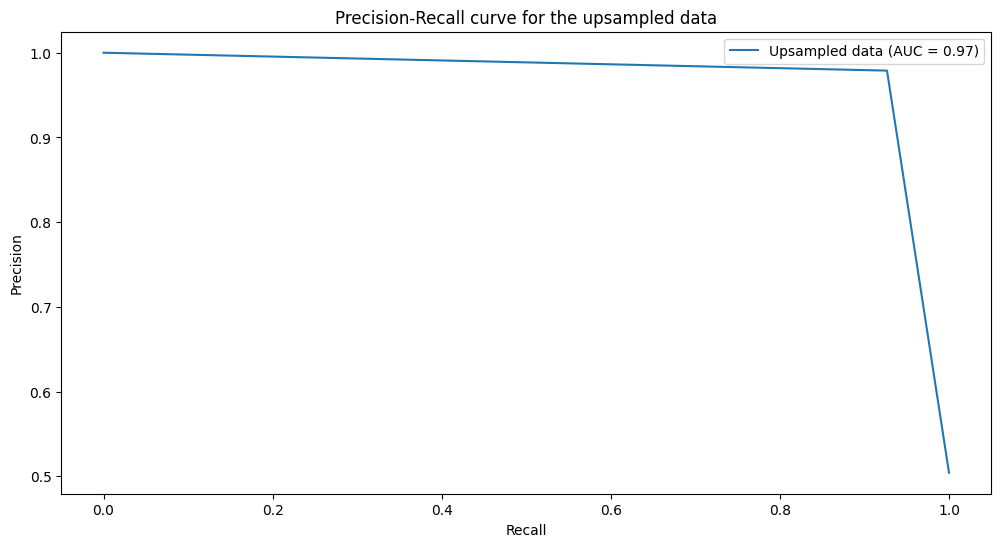

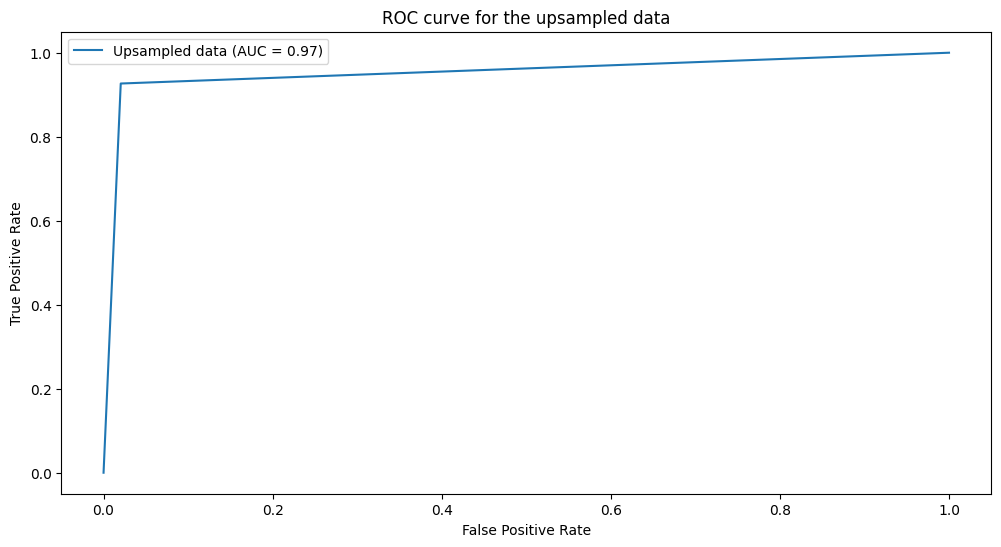

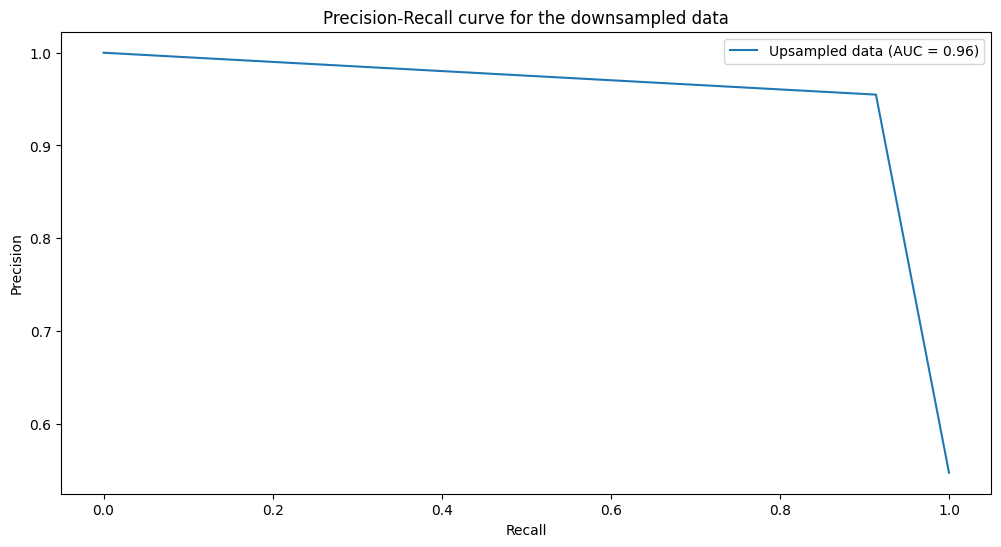

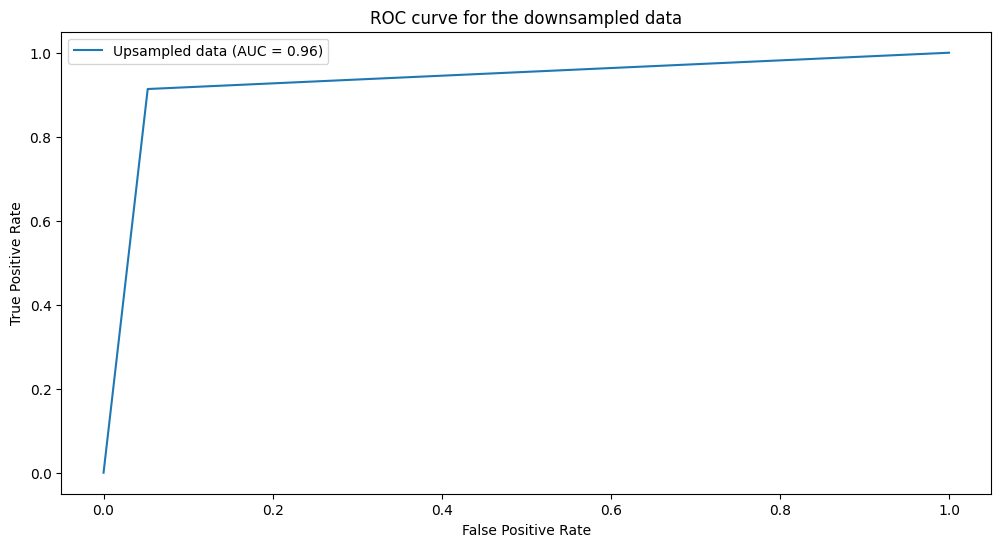

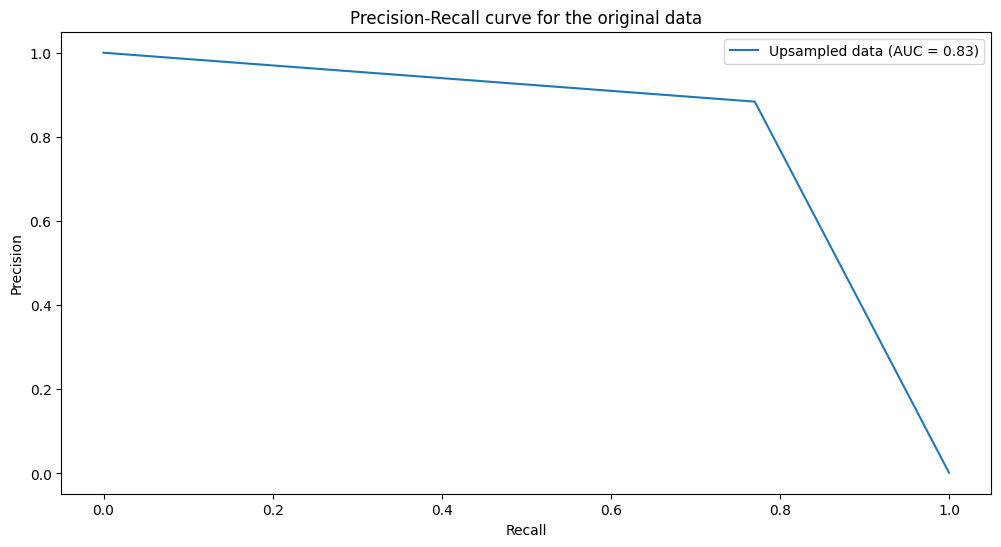

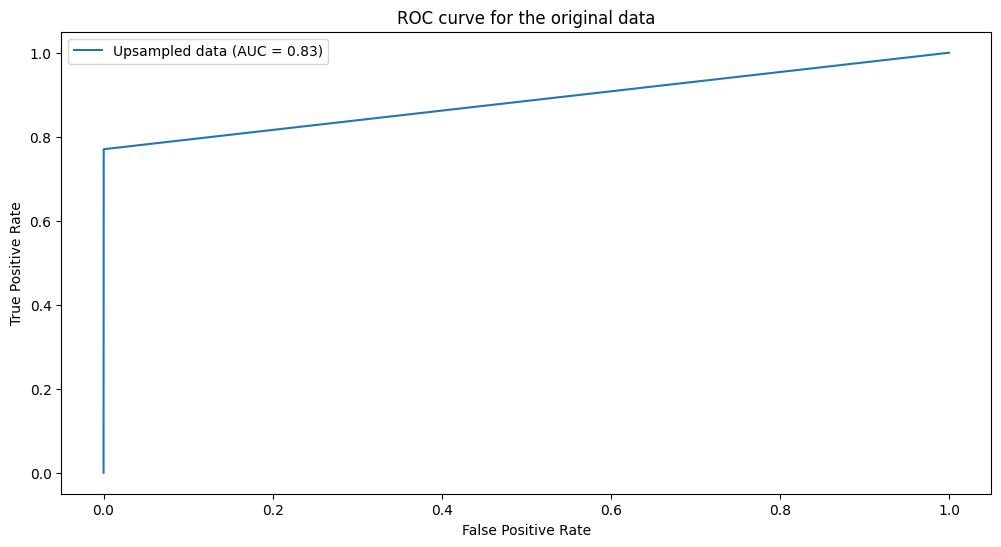

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

precision_up, recall_up, _ = precision_recall_curve(y_test_up, y_pred_up)

auc_score_up = auc(recall_up, precision_up)

plt.figure(figsize=(12,6))
plt.plot(recall_up, precision_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the upsampled data')
plt.legend()
plt.show()

fpr_up, tpr_up, _ = roc_curve(y_test_up, y_pred_up)

plt.figure(figsize=(12,6))
plt.plot(fpr_up, tpr_up, label=f'Upsampled data (AUC = {auc_score_up:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the upsampled data')
plt.legend()
plt.show()



precision_down, recall_down, _ = precision_recall_curve(y_test_down, y_pred_down)

auc_score_down = auc(recall_down, precision_down)

plt.figure(figsize=(12,6))
plt.plot(recall_down, precision_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the downsampled data')
plt.legend()
plt.show()

fpr_down, tpr_down, _ = roc_curve(y_test_down, y_pred_down)

plt.figure(figsize=(12,6))
plt.plot(fpr_down, tpr_down, label=f'Upsampled data (AUC = {auc_score_down:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the downsampled data')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.figure(figsize=(12,6))
plt.plot(recall, precision, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for the original data')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f'Upsampled data (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the original data')
plt.legend()
plt.show()